# CCLE Simple autoencoder 

In [1]:
from IPython.display import Image, display
from time import time
import re, sys, os
from keras import metrics
from sklearn.preprocessing import LabelEncoder, normalize
from keras.utils import plot_model, model_to_dot
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib. pyplot as plt 

user = '/rumi/shams/abe/'

Using TensorFlow backend.


Import CCLE data 

In [2]:
def read_data(user=user, dtype = 'counts'):
    t0 = time()
    data_folder = user + 'Datasets/CCLE/'
    m_rna_counts = data_folder + 'CCLE_RNAseq_genes_counts_20180929.gct.gz'
    m_rna_rpkm = data_folder + 'CCLE_RNAseq_genes_rpkm_20180929.gct.gz'
    cell_annotations = data_folder + 'Cell_lines_annotations_20181226.txt' 
    # select input format 
    if dtype == 'counts':
        m_rna = m_rna_counts
    elif dtype == 'rpkm':
        m_rna = m_rna_rpkm
    
    # read raw data
    raw_m_rna = pd.read_csv(m_rna, skiprows=2, sep='\t')

    # make meta data dictionary 
    meta = {'m_rna': raw_m_rna[['Name','Description']],
            'cell_lines':raw_m_rna.columns.values.tolist()[2:],
            'annotations':pd.read_csv(cell_annotations, sep='\t')
           }
    # normalize
    df_m_rna = raw_m_rna.drop(columns=['Name','Description']).to_numpy()
    df_m_rna = normalize(X=df_m_rna, axis=0, norm="max")
    data = {'df':df_m_rna, 'meta': meta}
    return data 

In [3]:
data = read_data()
cell_lines = data['meta']['cell_lines']
annotations = data['meta']['annotations']
df = data['df']

- https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

In [ ]:
from sklearn.decomposition import PCA
# Make an instance of the Model
pca = PCA(.95)

pca.fit(train_img)

# find out how many components PCA choose after fitting the model
pca.n_components_ 

train_img = pca.transform(train_img)
test_img = pca.transform(test_img)

Make autoencoder model:

In [26]:
def CCLE_autoencoder(df, user=user, save=False, plot=True,
                       test_size=0.10, 
                       n_en=1, n_de=1,dim_en=16,
                       batch_size=32, epochs =5):
    results_folder = user + 'Projects/GI_predictor/Results/'
    model_structure = 'dim-'+str(dim_en)+'-en-'+str(n_en)+'-de-'+str(n_de)
    model_path = results_folder+model_structure +"_batch_size_"+str(batch_size)+"_epochs-"+str(epochs)+'/'

    # custom R2-score metrics for keras backend
    def r_square(y_true, y_pred):
        from keras import backend as K
        SS_res =  K.sum(K.square(y_true - y_pred)) 
        SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
        return ( 1 - SS_res/(SS_tot + K.epsilon()) )


    def create_model(input_size):
        from keras.layers import Input, Dense
        from keras.models import Model
        from keras.callbacks import History, EarlyStopping 
        # this is our input placeholder
        myinput = Input(shape=(input_size,))

        ### hidden layers
        # encoding 
        n = n_en
        encoded = Dense(dim*(mu**n_en), activation='relu')(myinput)
        while n > 1:
            n-=1
            encoded = Dense(dim*(mu**n), activation='relu')(encoded)
        encoded = Dense(dim, activation='relu')(encoded)
        decoded = Dense(dim*mu, activation='relu')(encoded)
        # decoding 
        while n < n_de:
            n+=1
            decoded = Dense(dim*(mu**n), activation='relu')(decoded)
        decoded = Dense(input_size, activation='linear')(decoded)
        ### Separate encoder & autoencoder models
        autoencoder = Model(myinput, decoded)
        encoder = Model(myinput, encoded)
        autoencoder.compile(
            optimizer='adadelta', 
            loss='mse',
            metrics=[r_square]
        )
        return autoencoder, encoder
    
    # make X and y from df
    X = df.T
    y_true = X
    X_train, X_test,_,_ = train_test_split(X, X, test_size=test_size, random_state=42)
    # callbacks 
    history = History()
    early_stopping = EarlyStopping(monitor='val_loss', patience=20) 
    
    print (f'Input shape: {X.shape[0]} Cell lines X {X.shape[1]} RNAseq genes')
    print (f'Batch size {batch_size}, epochs {epochs}')
    
    # make, save plot and fit the model
    model, encoder = create_model(X.shape[1])   
    print(model.summary())
    
    model.fit(X_train, X_train,
              epochs=epochs,
              batch_size=batch_size,
              shuffle=False, # changed to false to keep val cell equal for comparing models 
              callbacks=[history,early_stopping],
              validation_data=(X_test, X_test)
             )
    print("fitting has just been finished")
    
    X_pred = model.predict(X_test, batch_size=batch_size, verbose=2)
    print("prediction process has just been finished")
    if save:    
        if not os.path.exists(model_path):
            os.mkdir(model_path)
        # save the model and encoded-layer output
        model.save(filepath=model_path+"model.h5")
        # save the result and prediction value
        np.savetxt(X=X_test, fname=model_path+"X_test.csv", delimiter=",")
        np.savetxt(X=X_pred[0], fname=model_path+"X_pred.csv", delimiter=",")
    if plot & early_stopping.stopped_epoch == 0:
        epochs = range(epochs)
        loss = model.history.history['loss']
        val_loss = model.history.history['val_loss']
        plt.figure()
        plt.plot(epochs, loss, 'bo', label='Training loss')
        plt.plot(epochs, val_loss, 'b', label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()
        if save:
            plt.savefig(model_path+'loss.pdf')
        plt.show()

        acc = model.history.history['r_square']
        val_acc = model.history.history['val_r_square']
        plt.figure() 
        plt.plot(epochs, acc, 'bo', label='Training r_square')
        plt.plot(epochs, val_acc, 'b', label='Validation r_square')
        plt.title('R^2')
        plt.ylabel('R^2') 
        plt.xlabel('Epoch')
        plt.legend(['Trian', 'Test'])

        if save:
            plt.savefig(model_path+'r_square.pdf')
        plt.show()

Input shape: 1019 Cell lines X 56202 RNAseq genes
Batch size 64, epochs 5
5 Hidden layers
Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 56202)             0         
_________________________________________________________________
dense_26 (Dense)             (None, 32)                1798496   
_________________________________________________________________
dense_27 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_28 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_29 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_30 (Dense)             (None, 56202)             1854666   
Total params: 3,654,506
Trainable 

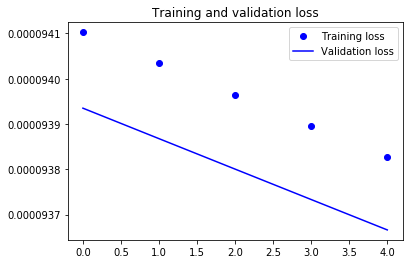

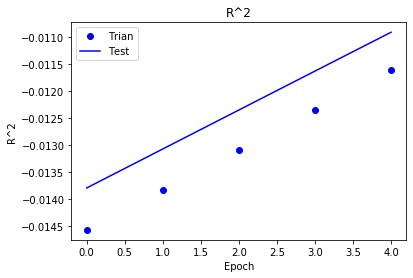

In [23]:
CCLE_autoencoder(df)

Input shape: 1019 Cell lines X 56202 RNAseq genes
Batch size 32, epochs 1000
Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 56202)             0         
_________________________________________________________________
dense_46 (Dense)             (None, 32)                1798496   
_________________________________________________________________
dense_47 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_48 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_49 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_50 (Dense)             (None, 56202)             1854666   
Total params: 3,654,506
Trainable params: 3,654

917/917 [==============================] - 3s 3ms/step - loss: 8.8366e-05 - r_square: 0.0475 - val_loss: 8.8301e-05 - val_r_square: 0.0473
Epoch 47/1000
917/917 [==============================] - 2s 2ms/step - loss: 8.8245e-05 - r_square: 0.0488 - val_loss: 8.8183e-05 - val_r_square: 0.0486
Epoch 48/1000
917/917 [==============================] - 2s 2ms/step - loss: 8.8125e-05 - r_square: 0.0501 - val_loss: 8.8066e-05 - val_r_square: 0.0499
Epoch 49/1000
917/917 [==============================] - 2s 3ms/step - loss: 8.8004e-05 - r_square: 0.0514 - val_loss: 8.7948e-05 - val_r_square: 0.0512
Epoch 50/1000
917/917 [==============================] - 3s 3ms/step - loss: 8.7884e-05 - r_square: 0.0527 - val_loss: 8.7831e-05 - val_r_square: 0.0525
Epoch 51/1000
917/917 [==============================] - 3s 3ms/step - loss: 8.7765e-05 - r_square: 0.0540 - val_loss: 8.7715e-05 - val_r_square: 0.0537
Epoch 52/1000
917/917 [==============================] - 3s 3ms/step - loss: 8.7645e-05 - r_squa

917/917 [==============================] - 2s 3ms/step - loss: 7.6871e-05 - r_square: 0.1718 - val_loss: 7.7095e-05 - val_r_square: 0.1693
Epoch 153/1000
917/917 [==============================] - 2s 3ms/step - loss: 7.6774e-05 - r_square: 0.1728 - val_loss: 7.7001e-05 - val_r_square: 0.1703
Epoch 154/1000
917/917 [==============================] - 2s 3ms/step - loss: 7.6677e-05 - r_square: 0.1739 - val_loss: 7.6906e-05 - val_r_square: 0.1713
Epoch 155/1000
917/917 [==============================] - 2s 3ms/step - loss: 7.6581e-05 - r_square: 0.1749 - val_loss: 7.6812e-05 - val_r_square: 0.1723
Epoch 156/1000
917/917 [==============================] - 2s 3ms/step - loss: 7.6485e-05 - r_square: 0.1760 - val_loss: 7.6719e-05 - val_r_square: 0.1734
Epoch 157/1000
917/917 [==============================] - 2s 3ms/step - loss: 7.6389e-05 - r_square: 0.1770 - val_loss: 7.6625e-05 - val_r_square: 0.1744
Epoch 158/1000
917/917 [==============================] - 2s 2ms/step - loss: 7.6293e-05 - 

Epoch 205/1000
917/917 [==============================] - 2s 3ms/step - loss: 7.2002e-05 - r_square: 0.2244 - val_loss: 7.2358e-05 - val_r_square: 0.2207
Epoch 206/1000
917/917 [==============================] - 3s 4ms/step - loss: 7.1915e-05 - r_square: 0.2253 - val_loss: 7.2274e-05 - val_r_square: 0.2217
Epoch 207/1000
917/917 [==============================] - 4s 4ms/step - loss: 7.1828e-05 - r_square: 0.2263 - val_loss: 7.2189e-05 - val_r_square: 0.2226
Epoch 208/1000
917/917 [==============================] - 2s 3ms/step - loss: 7.1742e-05 - r_square: 0.2272 - val_loss: 7.2105e-05 - val_r_square: 0.2235
Epoch 209/1000
917/917 [==============================] - 2s 2ms/step - loss: 7.1656e-05 - r_square: 0.2282 - val_loss: 7.2021e-05 - val_r_square: 0.2244
Epoch 210/1000
917/917 [==============================] - 3s 3ms/step - loss: 7.1570e-05 - r_square: 0.2291 - val_loss: 7.1938e-05 - val_r_square: 0.2253
Epoch 211/1000
917/917 [==============================] - 3s 3ms/step - loss

917/917 [==============================] - 2s 3ms/step - loss: 6.3726e-05 - r_square: 0.3138 - val_loss: 6.4326e-05 - val_r_square: 0.3079
Epoch 312/1000
917/917 [==============================] - 2s 2ms/step - loss: 6.3657e-05 - r_square: 0.3146 - val_loss: 6.4258e-05 - val_r_square: 0.3086
Epoch 313/1000
917/917 [==============================] - 2s 3ms/step - loss: 6.3587e-05 - r_square: 0.3153 - val_loss: 6.4191e-05 - val_r_square: 0.3093
Epoch 314/1000
917/917 [==============================] - 2s 2ms/step - loss: 6.3518e-05 - r_square: 0.3161 - val_loss: 6.4123e-05 - val_r_square: 0.3101
Epoch 315/1000
917/917 [==============================] - 3s 3ms/step - loss: 6.3448e-05 - r_square: 0.3168 - val_loss: 6.4056e-05 - val_r_square: 0.3108
Epoch 316/1000
917/917 [==============================] - 2s 3ms/step - loss: 6.3379e-05 - r_square: 0.3176 - val_loss: 6.3989e-05 - val_r_square: 0.3115
Epoch 317/1000
917/917 [==============================] - 2s 3ms/step - loss: 6.3310e-05 - 

917/917 [==============================] - 3s 4ms/step - loss: 5.7079e-05 - r_square: 0.3856 - val_loss: 5.7895e-05 - val_r_square: 0.3775
Epoch 418/1000
917/917 [==============================] - 3s 4ms/step - loss: 5.7023e-05 - r_square: 0.3863 - val_loss: 5.7841e-05 - val_r_square: 0.3780
Epoch 419/1000
917/917 [==============================] - 3s 4ms/step - loss: 5.6967e-05 - r_square: 0.3869 - val_loss: 5.7787e-05 - val_r_square: 0.3786
Epoch 420/1000
917/917 [==============================] - 3s 4ms/step - loss: 5.6911e-05 - r_square: 0.3875 - val_loss: 5.7733e-05 - val_r_square: 0.3792
Epoch 421/1000
917/917 [==============================] - 3s 4ms/step - loss: 5.6855e-05 - r_square: 0.3881 - val_loss: 5.7679e-05 - val_r_square: 0.3798
Epoch 422/1000
917/917 [==============================] - 3s 4ms/step - loss: 5.6800e-05 - r_square: 0.3887 - val_loss: 5.7625e-05 - val_r_square: 0.3804
Epoch 423/1000
917/917 [==============================] - 3s 3ms/step - loss: 5.6744e-05 - 

917/917 [==============================] - 2s 3ms/step - loss: 5.1738e-05 - r_square: 0.4433 - val_loss: 5.2748e-05 - val_r_square: 0.4330
Epoch 524/1000
917/917 [==============================] - 2s 3ms/step - loss: 5.1693e-05 - r_square: 0.4438 - val_loss: 5.2705e-05 - val_r_square: 0.4335
Epoch 525/1000
917/917 [==============================] - 2s 2ms/step - loss: 5.1648e-05 - r_square: 0.4443 - val_loss: 5.2662e-05 - val_r_square: 0.4339
Epoch 526/1000
917/917 [==============================] - 2s 2ms/step - loss: 5.1603e-05 - r_square: 0.4448 - val_loss: 5.2619e-05 - val_r_square: 0.4344
Epoch 527/1000
917/917 [==============================] - 2s 3ms/step - loss: 5.1559e-05 - r_square: 0.4453 - val_loss: 5.2576e-05 - val_r_square: 0.4349
Epoch 528/1000
917/917 [==============================] - 2s 2ms/step - loss: 5.1514e-05 - r_square: 0.4457 - val_loss: 5.2533e-05 - val_r_square: 0.4353
Epoch 529/1000
917/917 [==============================] - 2s 2ms/step - loss: 5.1470e-05 - 

917/917 [==============================] - 2s 3ms/step - loss: 4.7448e-05 - r_square: 0.4896 - val_loss: 4.8631e-05 - val_r_square: 0.4773
Epoch 630/1000
917/917 [==============================] - 2s 3ms/step - loss: 4.7412e-05 - r_square: 0.4900 - val_loss: 4.8597e-05 - val_r_square: 0.4777
Epoch 631/1000
917/917 [==============================] - 3s 3ms/step - loss: 4.7376e-05 - r_square: 0.4904 - val_loss: 4.8562e-05 - val_r_square: 0.4780
Epoch 632/1000
917/917 [==============================] - 2s 2ms/step - loss: 4.7340e-05 - r_square: 0.4908 - val_loss: 4.8528e-05 - val_r_square: 0.4784
Epoch 633/1000
917/917 [==============================] - 2s 2ms/step - loss: 4.7304e-05 - r_square: 0.4912 - val_loss: 4.8493e-05 - val_r_square: 0.4788
Epoch 634/1000
917/917 [==============================] - 2s 2ms/step - loss: 4.7268e-05 - r_square: 0.4916 - val_loss: 4.8459e-05 - val_r_square: 0.4791
Epoch 635/1000
917/917 [==============================] - 2s 3ms/step - loss: 4.7233e-05 - 

917/917 [==============================] - 2s 2ms/step - loss: 4.4003e-05 - r_square: 0.5268 - val_loss: 4.5340e-05 - val_r_square: 0.5126
Epoch 736/1000
917/917 [==============================] - 2s 3ms/step - loss: 4.3973e-05 - r_square: 0.5271 - val_loss: 4.5313e-05 - val_r_square: 0.5129
Epoch 737/1000
917/917 [==============================] - 2s 3ms/step - loss: 4.3944e-05 - r_square: 0.5274 - val_loss: 4.5285e-05 - val_r_square: 0.5132
Epoch 738/1000
917/917 [==============================] - 3s 3ms/step - loss: 4.3916e-05 - r_square: 0.5277 - val_loss: 4.5258e-05 - val_r_square: 0.5135
Epoch 739/1000
917/917 [==============================] - 2s 3ms/step - loss: 4.3887e-05 - r_square: 0.5280 - val_loss: 4.5230e-05 - val_r_square: 0.5138
Epoch 740/1000
917/917 [==============================] - 2s 3ms/step - loss: 4.3858e-05 - r_square: 0.5283 - val_loss: 4.5203e-05 - val_r_square: 0.5141
Epoch 741/1000
917/917 [==============================] - 3s 3ms/step - loss: 4.3829e-05 - 

917/917 [==============================] - 2s 2ms/step - loss: 4.1188e-05 - r_square: 0.5571 - val_loss: 4.2667e-05 - val_r_square: 0.5411
Epoch 844/1000
917/917 [==============================] - 2s 2ms/step - loss: 4.1165e-05 - r_square: 0.5574 - val_loss: 4.2645e-05 - val_r_square: 0.5414
Epoch 845/1000
917/917 [==============================] - 2s 2ms/step - loss: 4.1142e-05 - r_square: 0.5576 - val_loss: 4.2623e-05 - val_r_square: 0.5416
Epoch 846/1000
917/917 [==============================] - 2s 3ms/step - loss: 4.1118e-05 - r_square: 0.5579 - val_loss: 4.2601e-05 - val_r_square: 0.5418
Epoch 847/1000
917/917 [==============================] - 2s 3ms/step - loss: 4.1095e-05 - r_square: 0.5581 - val_loss: 4.2579e-05 - val_r_square: 0.5421
Epoch 848/1000
917/917 [==============================] - 2s 2ms/step - loss: 4.1072e-05 - r_square: 0.5584 - val_loss: 4.2557e-05 - val_r_square: 0.5423
Epoch 849/1000
917/917 [==============================] - 2s 3ms/step - loss: 4.1049e-05 - 

917/917 [==============================] - 2s 3ms/step - loss: 3.8974e-05 - r_square: 0.5810 - val_loss: 4.0576e-05 - val_r_square: 0.5634
Epoch 950/1000
917/917 [==============================] - 3s 3ms/step - loss: 3.8955e-05 - r_square: 0.5812 - val_loss: 4.0559e-05 - val_r_square: 0.5636
Epoch 951/1000
917/917 [==============================] - 3s 3ms/step - loss: 3.8937e-05 - r_square: 0.5814 - val_loss: 4.0541e-05 - val_r_square: 0.5638
Epoch 952/1000
917/917 [==============================] - 2s 3ms/step - loss: 3.8918e-05 - r_square: 0.5816 - val_loss: 4.0524e-05 - val_r_square: 0.5639
Epoch 953/1000
917/917 [==============================] - 2s 2ms/step - loss: 3.8900e-05 - r_square: 0.5818 - val_loss: 4.0506e-05 - val_r_square: 0.5641
Epoch 954/1000
917/917 [==============================] - 3s 4ms/step - loss: 3.8881e-05 - r_square: 0.5820 - val_loss: 4.0489e-05 - val_r_square: 0.5643
Epoch 955/1000
917/917 [==============================] - 4s 4ms/step - loss: 3.8863e-05 - 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



917/917 [==============================] - 3s 3ms/step - loss: 9.3960e-05 - r_square: -0.0130 - val_loss: 9.3762e-05 - val_r_square: -0.0121
Epoch 3/1000
917/917 [==============================] - 3s 4ms/step - loss: 9.3827e-05 - r_square: -0.0115 - val_loss: 9.3632e-05 - val_r_square: -0.0107
Epoch 4/1000
917/917 [==============================] - 3s 4ms/step - loss: 9.3693e-05 - r_square: -0.0101 - val_loss: 9.3501e-05 - val_r_square: -0.0093
Epoch 5/1000
917/917 [==============================] - 3s 3ms/step - loss: 9.3560e-05 - r_square: -0.0087 - val_loss: 9.3371e-05 - val_r_square: -0.0079
Epoch 6/1000
917/917 [==============================] - 3s 4ms/step - loss: 9.3428e-05 - r_square: -0.0072 - val_loss: 9.3242e-05 - val_r_square: -0.0065
Epoch 7/1000
917/917 [==============================] - 3s 3ms/step - loss: 9.3295e-05 - r_square: -0.0058 - val_loss: 9.3113e-05 - val_r_square: -0.0051
Epoch 8/1000
917/917 [==============================] - 3s 3ms/step - loss: 9.3163e-05 - 

917/917 [==============================] - 3s 3ms/step - loss: 8.1322e-05 - r_square: 0.1237 - val_loss: 8.1430e-05 - val_r_square: 0.1221
Epoch 109/1000
917/917 [==============================] - 3s 3ms/step - loss: 8.1216e-05 - r_square: 0.1248 - val_loss: 8.1326e-05 - val_r_square: 0.1233
Epoch 110/1000
917/917 [==============================] - 3s 4ms/step - loss: 8.1110e-05 - r_square: 0.1260 - val_loss: 8.1223e-05 - val_r_square: 0.1244
Epoch 111/1000
917/917 [==============================] - 3s 3ms/step - loss: 8.1004e-05 - r_square: 0.1271 - val_loss: 8.1120e-05 - val_r_square: 0.1255
Epoch 112/1000
917/917 [==============================] - 3s 3ms/step - loss: 8.0898e-05 - r_square: 0.1282 - val_loss: 8.1017e-05 - val_r_square: 0.1266
Epoch 113/1000
917/917 [==============================] - 3s 3ms/step - loss: 8.0793e-05 - r_square: 0.1294 - val_loss: 8.0915e-05 - val_r_square: 0.1277
Epoch 114/1000
917/917 [==============================] - 3s 3ms/step - loss: 8.0688e-05 - 

917/917 [==============================] - 3s 3ms/step - loss: 7.1203e-05 - r_square: 0.2330 - val_loss: 7.1581e-05 - val_r_square: 0.2292
Epoch 215/1000
917/917 [==============================] - 3s 3ms/step - loss: 7.1118e-05 - r_square: 0.2340 - val_loss: 7.1498e-05 - val_r_square: 0.2301
Epoch 216/1000
917/917 [==============================] - 3s 3ms/step - loss: 7.1033e-05 - r_square: 0.2349 - val_loss: 7.1416e-05 - val_r_square: 0.2310
Epoch 217/1000
917/917 [==============================] - 3s 3ms/step - loss: 7.0948e-05 - r_square: 0.2358 - val_loss: 7.1333e-05 - val_r_square: 0.2319
Epoch 218/1000
917/917 [==============================] - 3s 3ms/step - loss: 7.0863e-05 - r_square: 0.2367 - val_loss: 7.1251e-05 - val_r_square: 0.2328
Epoch 219/1000
917/917 [==============================] - 3s 3ms/step - loss: 7.0779e-05 - r_square: 0.2376 - val_loss: 7.1168e-05 - val_r_square: 0.2337
Epoch 220/1000
917/917 [==============================] - 3s 3ms/step - loss: 7.0694e-05 - 

917/917 [==============================] - 5s 5ms/step - loss: 6.3077e-05 - r_square: 0.3209 - val_loss: 6.3696e-05 - val_r_square: 0.3147
Epoch 321/1000
917/917 [==============================] - 4s 4ms/step - loss: 6.3009e-05 - r_square: 0.3216 - val_loss: 6.3630e-05 - val_r_square: 0.3154
Epoch 322/1000
917/917 [==============================] - 3s 4ms/step - loss: 6.2940e-05 - r_square: 0.3223 - val_loss: 6.3563e-05 - val_r_square: 0.3161
Epoch 323/1000
917/917 [==============================] - 5s 5ms/step - loss: 6.2872e-05 - r_square: 0.3231 - val_loss: 6.3497e-05 - val_r_square: 0.3168
Epoch 324/1000
917/917 [==============================] - 4s 5ms/step - loss: 6.2804e-05 - r_square: 0.3238 - val_loss: 6.3431e-05 - val_r_square: 0.3176
Epoch 325/1000
917/917 [==============================] - 4s 4ms/step - loss: 6.2736e-05 - r_square: 0.3245 - val_loss: 6.3366e-05 - val_r_square: 0.3183
Epoch 326/1000
917/917 [==============================] - 3s 3ms/step - loss: 6.2668e-05 - 

917/917 [==============================] - 3s 3ms/step - loss: 5.6551e-05 - r_square: 0.3913 - val_loss: 5.7385e-05 - val_r_square: 0.3830
Epoch 427/1000
917/917 [==============================] - 3s 3ms/step - loss: 5.6496e-05 - r_square: 0.3919 - val_loss: 5.7331e-05 - val_r_square: 0.3835
Epoch 428/1000
917/917 [==============================] - 3s 3ms/step - loss: 5.6441e-05 - r_square: 0.3925 - val_loss: 5.7278e-05 - val_r_square: 0.3841
Epoch 429/1000
917/917 [==============================] - 3s 3ms/step - loss: 5.6386e-05 - r_square: 0.3931 - val_loss: 5.7226e-05 - val_r_square: 0.3847
Epoch 430/1000
917/917 [==============================] - 3s 3ms/step - loss: 5.6331e-05 - r_square: 0.3937 - val_loss: 5.7173e-05 - val_r_square: 0.3853
Epoch 431/1000
917/917 [==============================] - 3s 3ms/step - loss: 5.6277e-05 - r_square: 0.3943 - val_loss: 5.7120e-05 - val_r_square: 0.3858
Epoch 432/1000
917/917 [==============================] - 3s 3ms/step - loss: 5.6222e-05 - 

917/917 [==============================] - 3s 4ms/step - loss: 5.1309e-05 - r_square: 0.4479 - val_loss: 5.2335e-05 - val_r_square: 0.4375
Epoch 533/1000
917/917 [==============================] - 3s 3ms/step - loss: 5.1265e-05 - r_square: 0.4484 - val_loss: 5.2292e-05 - val_r_square: 0.4379
Epoch 534/1000
917/917 [==============================] - 3s 4ms/step - loss: 5.1221e-05 - r_square: 0.4489 - val_loss: 5.2250e-05 - val_r_square: 0.4384
Epoch 535/1000
917/917 [==============================] - 4s 4ms/step - loss: 5.1176e-05 - r_square: 0.4494 - val_loss: 5.2207e-05 - val_r_square: 0.4388
Epoch 536/1000
917/917 [==============================] - 3s 4ms/step - loss: 5.1133e-05 - r_square: 0.4499 - val_loss: 5.2165e-05 - val_r_square: 0.4393
Epoch 537/1000
917/917 [==============================] - 3s 3ms/step - loss: 5.1089e-05 - r_square: 0.4503 - val_loss: 5.2123e-05 - val_r_square: 0.4397
Epoch 538/1000
917/917 [==============================] - 3s 3ms/step - loss: 5.1045e-05 - 

917/917 [==============================] - 3s 3ms/step - loss: 4.7099e-05 - r_square: 0.4934 - val_loss: 4.8296e-05 - val_r_square: 0.4809
Epoch 639/1000
917/917 [==============================] - 3s 3ms/step - loss: 4.7063e-05 - r_square: 0.4938 - val_loss: 4.8262e-05 - val_r_square: 0.4813
Epoch 640/1000
917/917 [==============================] - 3s 3ms/step - loss: 4.7028e-05 - r_square: 0.4942 - val_loss: 4.8228e-05 - val_r_square: 0.4816
Epoch 641/1000
917/917 [==============================] - 3s 3ms/step - loss: 4.6992e-05 - r_square: 0.4945 - val_loss: 4.8194e-05 - val_r_square: 0.4820
Epoch 642/1000
917/917 [==============================] - 3s 3ms/step - loss: 4.6957e-05 - r_square: 0.4949 - val_loss: 4.8161e-05 - val_r_square: 0.4824
Epoch 643/1000
917/917 [==============================] - 3s 3ms/step - loss: 4.6922e-05 - r_square: 0.4953 - val_loss: 4.8127e-05 - val_r_square: 0.4827
Epoch 644/1000
917/917 [==============================] - 3s 3ms/step - loss: 4.6887e-05 - 

917/917 [==============================] - 3s 4ms/step - loss: 4.3717e-05 - r_square: 0.5299 - val_loss: 4.5068e-05 - val_r_square: 0.5155
Epoch 745/1000
917/917 [==============================] - 3s 3ms/step - loss: 4.3689e-05 - r_square: 0.5302 - val_loss: 4.5041e-05 - val_r_square: 0.5158
Epoch 746/1000
917/917 [==============================] - 3s 3ms/step - loss: 4.3660e-05 - r_square: 0.5305 - val_loss: 4.5014e-05 - val_r_square: 0.5161
Epoch 747/1000
917/917 [==============================] - 3s 3ms/step - loss: 4.3632e-05 - r_square: 0.5308 - val_loss: 4.4987e-05 - val_r_square: 0.5164
Epoch 748/1000
917/917 [==============================] - 3s 3ms/step - loss: 4.3604e-05 - r_square: 0.5311 - val_loss: 4.4960e-05 - val_r_square: 0.5167
Epoch 749/1000
917/917 [==============================] - 3s 3ms/step - loss: 4.3575e-05 - r_square: 0.5314 - val_loss: 4.4933e-05 - val_r_square: 0.5170
Epoch 750/1000
917/917 [==============================] - 3s 3ms/step - loss: 4.3547e-05 - 

917/917 [==============================] - 3s 4ms/step - loss: 4.1002e-05 - r_square: 0.5591 - val_loss: 4.2490e-05 - val_r_square: 0.5430
Epoch 851/1000
917/917 [==============================] - 3s 3ms/step - loss: 4.0979e-05 - r_square: 0.5594 - val_loss: 4.2468e-05 - val_r_square: 0.5433
Epoch 852/1000
917/917 [==============================] - 3s 3ms/step - loss: 4.0956e-05 - r_square: 0.5596 - val_loss: 4.2446e-05 - val_r_square: 0.5435
Epoch 853/1000
917/917 [==============================] - 3s 3ms/step - loss: 4.0933e-05 - r_square: 0.5599 - val_loss: 4.2425e-05 - val_r_square: 0.5437
Epoch 854/1000
917/917 [==============================] - 3s 3ms/step - loss: 4.0910e-05 - r_square: 0.5601 - val_loss: 4.2403e-05 - val_r_square: 0.5440
Epoch 855/1000
917/917 [==============================] - 3s 3ms/step - loss: 4.0888e-05 - r_square: 0.5604 - val_loss: 4.2382e-05 - val_r_square: 0.5442
Epoch 856/1000
917/917 [==============================] - 3s 3ms/step - loss: 4.0865e-05 - 

917/917 [==============================] - 3s 3ms/step - loss: 3.8821e-05 - r_square: 0.5826 - val_loss: 4.0432e-05 - val_r_square: 0.5649
Epoch 957/1000
917/917 [==============================] - 3s 3ms/step - loss: 3.8803e-05 - r_square: 0.5828 - val_loss: 4.0414e-05 - val_r_square: 0.5651
Epoch 958/1000
917/917 [==============================] - 3s 3ms/step - loss: 3.8784e-05 - r_square: 0.5830 - val_loss: 4.0397e-05 - val_r_square: 0.5653
Epoch 959/1000
917/917 [==============================] - 3s 3ms/step - loss: 3.8766e-05 - r_square: 0.5832 - val_loss: 4.0380e-05 - val_r_square: 0.5655
Epoch 960/1000
917/917 [==============================] - 3s 3ms/step - loss: 3.8748e-05 - r_square: 0.5834 - val_loss: 4.0363e-05 - val_r_square: 0.5657
Epoch 961/1000
917/917 [==============================] - 3s 3ms/step - loss: 3.8729e-05 - r_square: 0.5836 - val_loss: 4.0346e-05 - val_r_square: 0.5658
Epoch 962/1000
917/917 [==============================] - 3s 3ms/step - loss: 3.8711e-05 - 

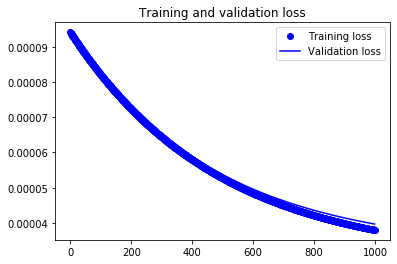

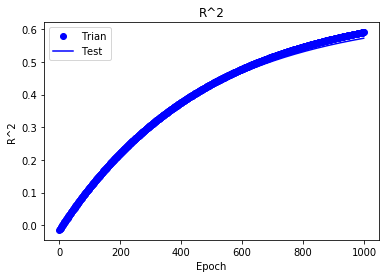

Input shape: 1019 Cell lines X 56202 RNAseq genes
Batch size 32, epochs 1000
Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 56202)             0         
_________________________________________________________________
dense_60 (Dense)             (None, 64)                3596992   
_________________________________________________________________
dense_61 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_62 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_63 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_64 (Dense)             (None, 56202)             3653130   
Total params: 7,255,370
Trainable params: 7,255

917/917 [==============================] - 2s 3ms/step - loss: 8.8356e-05 - r_square: 0.0476 - val_loss: 8.8291e-05 - val_r_square: 0.0474
Epoch 47/1000
917/917 [==============================] - 3s 3ms/step - loss: 8.8236e-05 - r_square: 0.0489 - val_loss: 8.8174e-05 - val_r_square: 0.0487
Epoch 48/1000
917/917 [==============================] - 4s 5ms/step - loss: 8.8115e-05 - r_square: 0.0502 - val_loss: 8.8056e-05 - val_r_square: 0.0500
Epoch 49/1000
917/917 [==============================] - 3s 3ms/step - loss: 8.7995e-05 - r_square: 0.0515 - val_loss: 8.7939e-05 - val_r_square: 0.0513
Epoch 50/1000
917/917 [==============================] - 3s 3ms/step - loss: 8.7875e-05 - r_square: 0.0528 - val_loss: 8.7822e-05 - val_r_square: 0.0526
Epoch 51/1000
917/917 [==============================] - 3s 4ms/step - loss: 8.7755e-05 - r_square: 0.0541 - val_loss: 8.7705e-05 - val_r_square: 0.0538
Epoch 52/1000
917/917 [==============================] - 4s 4ms/step - loss: 8.7636e-05 - r_squa

917/917 [==============================] - 3s 3ms/step - loss: 7.6859e-05 - r_square: 0.1719 - val_loss: 7.7082e-05 - val_r_square: 0.1694
Epoch 153/1000
917/917 [==============================] - 3s 3ms/step - loss: 7.6762e-05 - r_square: 0.1730 - val_loss: 7.6988e-05 - val_r_square: 0.1704
Epoch 154/1000
917/917 [==============================] - 3s 3ms/step - loss: 7.6665e-05 - r_square: 0.1740 - val_loss: 7.6894e-05 - val_r_square: 0.1715
Epoch 155/1000
917/917 [==============================] - 2s 3ms/step - loss: 7.6569e-05 - r_square: 0.1750 - val_loss: 7.6800e-05 - val_r_square: 0.1725
Epoch 156/1000
917/917 [==============================] - 2s 3ms/step - loss: 7.6473e-05 - r_square: 0.1761 - val_loss: 7.6706e-05 - val_r_square: 0.1735
Epoch 157/1000
917/917 [==============================] - 2s 3ms/step - loss: 7.6376e-05 - r_square: 0.1771 - val_loss: 7.6613e-05 - val_r_square: 0.1745
Epoch 158/1000
917/917 [==============================] - 3s 3ms/step - loss: 7.6281e-05 - 

917/917 [==============================] - 3s 3ms/step - loss: 6.7624e-05 - r_square: 0.2717 - val_loss: 6.8105e-05 - val_r_square: 0.2669
Epoch 259/1000
917/917 [==============================] - 3s 3ms/step - loss: 6.7546e-05 - r_square: 0.2726 - val_loss: 6.8029e-05 - val_r_square: 0.2677
Epoch 260/1000
917/917 [==============================] - 3s 3ms/step - loss: 6.7469e-05 - r_square: 0.2734 - val_loss: 6.7954e-05 - val_r_square: 0.2685
Epoch 261/1000
917/917 [==============================] - 3s 3ms/step - loss: 6.7391e-05 - r_square: 0.2742 - val_loss: 6.7878e-05 - val_r_square: 0.2693
Epoch 262/1000
917/917 [==============================] - 3s 3ms/step - loss: 6.7314e-05 - r_square: 0.2751 - val_loss: 6.7803e-05 - val_r_square: 0.2702
Epoch 263/1000
917/917 [==============================] - 3s 3ms/step - loss: 6.7236e-05 - r_square: 0.2759 - val_loss: 6.7728e-05 - val_r_square: 0.2710
Epoch 264/1000
917/917 [==============================] - 3s 3ms/step - loss: 6.7159e-05 - 

917/917 [==============================] - 3s 3ms/step - loss: 6.0206e-05 - r_square: 0.3519 - val_loss: 6.0916e-05 - val_r_square: 0.3448
Epoch 365/1000
917/917 [==============================] - 3s 3ms/step - loss: 6.0143e-05 - r_square: 0.3525 - val_loss: 6.0855e-05 - val_r_square: 0.3454
Epoch 366/1000
917/917 [==============================] - 3s 3ms/step - loss: 6.0081e-05 - r_square: 0.3532 - val_loss: 6.0795e-05 - val_r_square: 0.3461
Epoch 367/1000
917/917 [==============================] - 3s 4ms/step - loss: 6.0018e-05 - r_square: 0.3539 - val_loss: 6.0734e-05 - val_r_square: 0.3467
Epoch 368/1000
917/917 [==============================] - 3s 3ms/step - loss: 5.9956e-05 - r_square: 0.3546 - val_loss: 6.0674e-05 - val_r_square: 0.3474
Epoch 369/1000
917/917 [==============================] - 3s 3ms/step - loss: 5.9894e-05 - r_square: 0.3552 - val_loss: 6.0614e-05 - val_r_square: 0.3480
Epoch 370/1000
917/917 [==============================] - 3s 3ms/step - loss: 5.9832e-05 - 

917/917 [==============================] - 3s 3ms/step - loss: 5.4246e-05 - r_square: 0.4162 - val_loss: 5.5161e-05 - val_r_square: 0.4070
Epoch 471/1000
917/917 [==============================] - 3s 3ms/step - loss: 5.4196e-05 - r_square: 0.4168 - val_loss: 5.5113e-05 - val_r_square: 0.4075
Epoch 472/1000
917/917 [==============================] - 3s 3ms/step - loss: 5.4146e-05 - r_square: 0.4173 - val_loss: 5.5065e-05 - val_r_square: 0.4080
Epoch 473/1000
917/917 [==============================] - 3s 3ms/step - loss: 5.4096e-05 - r_square: 0.4179 - val_loss: 5.5016e-05 - val_r_square: 0.4085
Epoch 474/1000
917/917 [==============================] - 3s 3ms/step - loss: 5.4046e-05 - r_square: 0.4184 - val_loss: 5.4968e-05 - val_r_square: 0.4091
Epoch 475/1000
917/917 [==============================] - 3s 3ms/step - loss: 5.3996e-05 - r_square: 0.4189 - val_loss: 5.4920e-05 - val_r_square: 0.4096
Epoch 476/1000
917/917 [==============================] - 3s 3ms/step - loss: 5.3946e-05 - 

917/917 [==============================] - 3s 3ms/step - loss: 4.9459e-05 - r_square: 0.4679 - val_loss: 5.0558e-05 - val_r_square: 0.4566
Epoch 577/1000
917/917 [==============================] - 2s 3ms/step - loss: 4.9419e-05 - r_square: 0.4683 - val_loss: 5.0519e-05 - val_r_square: 0.4570
Epoch 578/1000
917/917 [==============================] - 3s 3ms/step - loss: 4.9378e-05 - r_square: 0.4688 - val_loss: 5.0480e-05 - val_r_square: 0.4574
Epoch 579/1000
917/917 [==============================] - 2s 3ms/step - loss: 4.9338e-05 - r_square: 0.4692 - val_loss: 5.0442e-05 - val_r_square: 0.4578
Epoch 580/1000
917/917 [==============================] - 3s 3ms/step - loss: 4.9298e-05 - r_square: 0.4697 - val_loss: 5.0403e-05 - val_r_square: 0.4582
Epoch 581/1000
917/917 [==============================] - 3s 3ms/step - loss: 4.9258e-05 - r_square: 0.4701 - val_loss: 5.0365e-05 - val_r_square: 0.4587
Epoch 582/1000
917/917 [==============================] - 3s 3ms/step - loss: 4.9218e-05 - 

917/917 [==============================] - 3s 3ms/step - loss: 4.5614e-05 - r_square: 0.5094 - val_loss: 4.6876e-05 - val_r_square: 0.4961
Epoch 683/1000
917/917 [==============================] - 3s 3ms/step - loss: 4.5582e-05 - r_square: 0.5098 - val_loss: 4.6845e-05 - val_r_square: 0.4965
Epoch 684/1000
917/917 [==============================] - 3s 3ms/step - loss: 4.5549e-05 - r_square: 0.5101 - val_loss: 4.6814e-05 - val_r_square: 0.4968
Epoch 685/1000
917/917 [==============================] - 3s 3ms/step - loss: 4.5517e-05 - r_square: 0.5105 - val_loss: 4.6784e-05 - val_r_square: 0.4971
Epoch 686/1000
917/917 [==============================] - 3s 3ms/step - loss: 4.5485e-05 - r_square: 0.5108 - val_loss: 4.6753e-05 - val_r_square: 0.4975
Epoch 687/1000
917/917 [==============================] - 3s 3ms/step - loss: 4.5453e-05 - r_square: 0.5111 - val_loss: 4.6722e-05 - val_r_square: 0.4978
Epoch 688/1000
917/917 [==============================] - 3s 3ms/step - loss: 4.5421e-05 - 

Epoch 788/1000
917/917 [==============================] - 3s 3ms/step - loss: 4.2526e-05 - r_square: 0.5427 - val_loss: 4.3934e-05 - val_r_square: 0.5276
Epoch 789/1000
917/917 [==============================] - 3s 3ms/step - loss: 4.2500e-05 - r_square: 0.5430 - val_loss: 4.3910e-05 - val_r_square: 0.5279
Epoch 790/1000
917/917 [==============================] - 3s 3ms/step - loss: 4.2474e-05 - r_square: 0.5433 - val_loss: 4.3885e-05 - val_r_square: 0.5281
Epoch 791/1000
917/917 [==============================] - 3s 3ms/step - loss: 4.2448e-05 - r_square: 0.5436 - val_loss: 4.3860e-05 - val_r_square: 0.5284
Epoch 792/1000
917/917 [==============================] - 3s 3ms/step - loss: 4.2422e-05 - r_square: 0.5438 - val_loss: 4.3836e-05 - val_r_square: 0.5287
Epoch 793/1000
917/917 [==============================] - 3s 3ms/step - loss: 4.2396e-05 - r_square: 0.5441 - val_loss: 4.3811e-05 - val_r_square: 0.5289
Epoch 794/1000
917/917 [==============================] - 3s 3ms/step - loss

917/917 [==============================] - 2s 3ms/step - loss: 4.0045e-05 - r_square: 0.5694 - val_loss: 4.1585e-05 - val_r_square: 0.5527
Epoch 895/1000
917/917 [==============================] - 2s 3ms/step - loss: 4.0024e-05 - r_square: 0.5697 - val_loss: 4.1565e-05 - val_r_square: 0.5529
Epoch 896/1000
917/917 [==============================] - 2s 3ms/step - loss: 4.0003e-05 - r_square: 0.5699 - val_loss: 4.1545e-05 - val_r_square: 0.5531
Epoch 897/1000
917/917 [==============================] - 2s 3ms/step - loss: 3.9983e-05 - r_square: 0.5701 - val_loss: 4.1526e-05 - val_r_square: 0.5533
Epoch 898/1000
917/917 [==============================] - 2s 2ms/step - loss: 3.9962e-05 - r_square: 0.5703 - val_loss: 4.1506e-05 - val_r_square: 0.5535
Epoch 899/1000
917/917 [==============================] - 2s 2ms/step - loss: 3.9941e-05 - r_square: 0.5706 - val_loss: 4.1487e-05 - val_r_square: 0.5537
Epoch 900/1000
917/917 [==============================] - 2s 3ms/step - loss: 3.9920e-05 - 

917/917 [==============================] - 3s 3ms/step - loss: 3.8053e-05 - r_square: 0.5909 - val_loss: 3.9710e-05 - val_r_square: 0.5726
fitting has just been finished
prediction process has just been finished


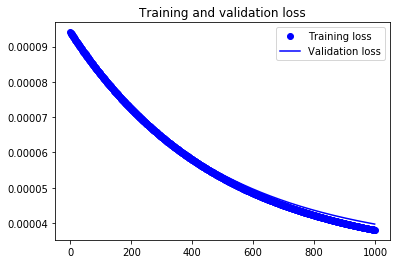

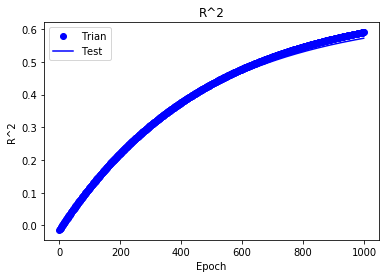

Input shape: 1019 Cell lines X 56202 RNAseq genes
Batch size 32, epochs 1000
Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 56202)             0         
_________________________________________________________________
dense_65 (Dense)             (None, 256)               14387968  
_________________________________________________________________
dense_66 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_67 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_68 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_71 (Dense)             (None, 128)               4224      
_______________________________________________

In [ ]:
for dim in [16,32]:
    for n in [1,3]:
        CCLE_autoencoder(df, epochs=1000, 
                         n_en=n, n_de=n,
                         dim_en=dim,
                         save=True
                        )

In [38]:
[[i, cell] for i, cell in enumerate(cell_lines) if 'K562' in cell ]

[[385, 'K562_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE']]

In [43]:
[[i, cell] for i, cell in enumerate(cell_lines) if 'JURKAT' in cell ]

[[380, 'JURKAT_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE']]

## Now you can use these pre-trained models